# CS669 - Pattern Recognition
## Assignment 1 - Bayesian Classification

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

In [3]:
def split_train_test(data, split_ratio):
    train = data.sample(frac=split_ratio, random_state=42)
    test = data.drop(train.index)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    return train, test

In [43]:
# data1 = pd.read_csv('LS_Group03/Class1.txt', sep=' ', names=['X','Y'], dtype='float64')
# data2 = pd.read_csv('LS_Group03/Class2.txt', sep=' ', names=['X','Y'], dtype='float64')
# data3 = pd.read_csv('LS_Group03/Class3.txt', sep=' ', names=['X','Y'], dtype='float64')

data1 = pd.read_csv('NLS.txt', sep=' ', names=['X','Y'], dtype='float64').iloc[:300, :2]
data2 = pd.read_csv('NLS.txt', sep=' ', names=['X','Y'], dtype='float64').iloc[300:800, :2]
data3 = pd.read_csv('NLS.txt', sep=' ', names=['X','Y'], dtype='float64').iloc[800:1800, :2]

# data1 = pd.read_csv('rd_group3/Class1.txt', sep=' ', names=['X','Y'], dtype='float64')
# data2 = pd.read_csv('rd_group3/Class2.txt', sep=' ', names=['X','Y'], dtype='float64')
# data3 = pd.read_csv('rd_group3/Class3.txt', sep=' ', names=['X','Y'], dtype='float64')

data = {1: data1, 2: data2, 3: data3}

data_min_x = min(data1['X'].min(), data2['X'].min(), data3['X'].min())
data_min_y = min(data1['Y'].min(), data2['Y'].min(), data3['Y'].min())

data_max_x = min(data1['X'].max(), data2['X'].max(), data3['X'].max())
data_max_y = max(data1['X'].max(), data2['Y'].max(), data3['Y'].max())

train_c1, test_c1 = split_train_test(data1, 0.70)
train_c2, test_c2 = split_train_test(data2, 0.70)
train_c3, test_c3 = split_train_test(data3, 0.70)

train = {1: train_c1, 2: train_c2, 3: train_c3}
test = {1: test_c1, 2: test_c2, 3: test_c3}

c1_min_x, c1_min_y = train_c1['X'].min, train_c1['Y'].max
c2_min_x, c2_min_y = train_c2['X'].min, train_c2['Y'].max
c3_min_x, c3_min_y = train_c3['X'].min, train_c3['Y'].max

In [6]:
def calculate_prior(data):
    prior = []
    prior.append(data[1].shape[0] / (data[1].shape[0] + data[2].shape[0] + data[3].shape[0]))
    prior.append(data[2].shape[0] / (data[1].shape[0] + data[2].shape[0] + data[3].shape[0]))
    prior.append(data[3].shape[0] / (data[1].shape[0] + data[2].shape[0] + data[3].shape[0]))
    return prior

In [7]:
# gi(x) = transpose(w_i) * x + w_i0
# x = point
# w_i = mu_i/variance
# w_i0 = (-1/(2*variance)) * (mu_transpose * mu) + ln(P(omega_i))
# Ignoring prior as it'll be same = 1/3 in all cases.
def discriminant_func1(x, mean, cov_sigma, i, data):
    prior = calculate_prior(data)
    sigma = (cov_sigma[0] + cov_sigma[1] + cov_sigma[2]) / 3
    variance = (sigma[0][0] + sigma[1][1]) / 2
    w = mean[i-1] / variance
    w0 = (-1/(2*variance)) * np.matmul(np.transpose(mean[i-1]), mean[i-1]) + np.log(prior[i-1])
    g = np.matmul(np.transpose(w), x) + w0
#     print(g)
    return g.item()

In [8]:
def discriminant_func2(x, mean, cov_sigma, i, data):
    prior = calculate_prior(data)
    sigma = (cov_sigma[0] + cov_sigma[1] + cov_sigma[2]) / 3
    
    w =  np.matmul(np.linalg.inv(sigma), mean[i-1])
    w0 = -0.5 * np.linalg.multi_dot([np.transpose(mean[i-1]), np.linalg.inv(sigma), mean[i-1]]) + np.log(prior[i-1])
    g = np.matmul(np.transpose(w), x) + w0
#     print('g2 = {}'.format(g))
    return g.item()

In [9]:
def discriminant_func3(x, mean, cov_sigma, i, data):
    prior = calculate_prior(data)
    sigma = cov_sigma
    W_i = -0.5 * np.linalg.inv(sigma[i-1])
    w_i = np.matmul(np.linalg.inv(sigma[i-1]), mean[i-1])
    w0_i = -0.5 * np.linalg.multi_dot([np.transpose(mean[i-1]), np.linalg.inv(sigma[i-1]), mean[i-1]]) - 0.5 * (np.log(np.linalg.det(sigma[i-1]))) + np.log(prior[i-1])
    g_i = np.linalg.multi_dot([np.transpose(x), W_i, x]) + np.matmul(np.transpose(w_i), x) + w0_i

    return g_i.item()

In [10]:
def discriminant_func4(x, mean, cov_sigma, i, data):
    prior = calculate_prior(data)
    sigma = cov_sigma
    W_i = -0.5 * np.linalg.inv(sigma[i-1])
    w_i = np.matmul(np.linalg.inv(sigma[i-1]), mean[i-1])
    w0_i = -0.5 * np.linalg.multi_dot([np.transpose(mean[i-1]), np.linalg.inv(sigma[i-1]), mean[i-1]]) - 0.5 * (np.log(np.linalg.det(sigma[i-1])) + np.log(prior[i-1]))
    g_i = np.linalg.multi_dot([np.transpose(x), W_i, x]) + np.matmul(np.transpose(w_i), x) + w0_i

    return g_i.item()

In [46]:
mean_mat = []

mean_mat.append(np.array([train[1].iloc[:, 0].mean(), train[1].iloc[:, 1].mean()]).reshape((2, 1)))
mean_mat.append(np.array([train[2].iloc[:, 0].mean(), train[2].iloc[:, 1].mean()]).reshape((2, 1)))
mean_mat.append(np.array([train[3].iloc[:, 0].mean(), train[3].iloc[:, 1].mean()]).reshape((2, 1)))

cov1 = np.cov(train[1]['X'], train[1]['Y'])
cov2 = np.cov(train[2]['X'], train[2]['Y'])
cov3 = np.cov(train[3]['X'], train[3]['Y'])

# print('mean1 = {}\nmean2 = {}\nmean3 = {}'.format(mean_mat[0], mean_mat[1], mean_mat[2]))
# print('cov1 = \n{}\ncov2 = \n{}\ncov3 = \n{}\n'.format(cov1, cov2, cov3))

# For case 1, sigma = var^2 I
cov_sigma = [cov1, cov2, cov3]

# plot_contour(train, mean_mat, cov_sigma, 1, data, x_min=-8, x_max=30, y_min=-20, y_max=15, steps=500, smoothness=0.5)
testing(test, 1, mean_mat, cov_sigma, data)

Confusion Matrix:
[[  0   0  90]
 [  0   0 150]
 [  0  97 203]]

Accuracy = 0.37592592592592594

Precision for
Class 1: 0.0
Class 2: 0.0
Class 3: 0.6766666666666666

Recall for
Class 1: nan
Class 2: 0.0
Class 3: 0.4582392776523702

F-score for
Class 1: nan
Class 2: nan
Class 3: 0.5464333781965006

Mean precision = 
0.22555555555555554

Mean recall = 
nan
Mean fscore = 
nan


/home/ancientfuture/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/home/ancientfuture/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plot_contour(train, mean_mat, cov_sigma, 2, data, x_min=-8, x_max=25, y_min=-20, y_max=15, steps=300, smoothness=0.5)
testing(test, 2, mean_mat, cov_sigma, data)

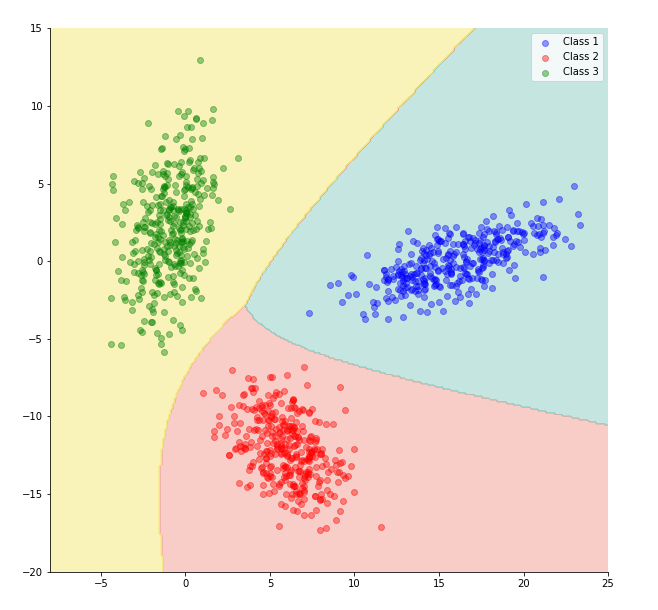

Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]
Accuracy = 1.0
Precision for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
Recall for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
F-score for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
Mean precision = 
1.0
Mean recall = 
1.0
Mean fscore = 
1.0


In [39]:
plot_contour(train, mean_mat, cov_sigma, 3, data, x_min=-8, x_max=25, y_min=-20, y_max=15, steps=300, smoothness=0.5)
testing(test, 3, mean_mat, cov_sigma, data)

In [38]:
# plot_contour(train, mean_mat, cov_sigma, 4, data, x_min=-10, x_max=10, y_min=-10, y_max=10, steps=300, smoothness=0.5)
testing(test, 4, mean_mat, cov_sigma, data)

Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]
Accuracy = 1.0
Precision for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
Recall for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
F-score for
Class 1: 1.0
Class 2: 1.0
Class 3: 1.0
Mean precision = 
1.0
Mean recall = 
1.0
Mean fscore = 
1.0


In [12]:
def predict_class(point, m, sigma, flag, data):
    tmp = []
    if flag == 1:
        g_i = discriminant_func1(point, m, sigma, 1, data)
        g_j = discriminant_func1(point, m, sigma, 2, data)
        g_k = discriminant_func1(point, m, sigma, 3, data)
    elif flag == 2:
        g_i = discriminant_func2(point, m, sigma, 1, data)
        g_j = discriminant_func2(point, m, sigma, 2, data)
        g_k = discriminant_func2(point, m, sigma, 3, data)
    elif flag == 3:
        g_i = discriminant_func3(point, m, sigma, 1, data)
        g_j = discriminant_func3(point, m, sigma, 2, data)
        g_k = discriminant_func3(point, m, sigma, 3, data)
    elif flag == 4:
        g_i = discriminant_func4(point, m, sigma, 1, data)
        g_j = discriminant_func4(point, m, sigma, 2, data)
        g_k = discriminant_func4(point, m, sigma, 3, data)

    tmp.append(g_i)
    tmp.append(g_j)
    tmp.append(g_k)
    index = tmp.index(max(tmp))
    return index+1

In [47]:
def plot_contour(train, m, sigma, flag, data, x_min, y_min, x_max, y_max, steps=750, smoothness=0.5):
    bg = ['#8ACCC3', '#F39C91', '#F4E874']
    colors_pt = ['blue', 'red', 'green']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    x = np.linspace(x_min, x_max, steps, dtype='float64')
    y = np.linspace(y_min, y_max, steps, dtype='float64')
    g = np.meshgrid(x, y)
    X1, X2 = np.meshgrid(x, y)
    z = np.array([])
    count = 1

    for mesh_point in zip(*(x.flat for x in g)):
#         print(count)
        point = np.array(mesh_point).reshape((2, 1))
        predicted_class = predict_class(point, m, sigma, flag, data)
        z = np.append(z, predicted_class)
        count += 1
    
    Z = z.reshape(X1.shape)

    plt.contourf(X1, X2, Z, alpha = 0.50, cmap = ListedColormap(('#8ACCC3', '#F39C91', '#F4E874')))
    ax.scatter(train[1]['X'], train[1]['Y'], color=colors_pt[0], label='Class ' + str(1), alpha=0.40)
    ax.scatter(train[2]['X'], train[2]['Y'], color=colors_pt[1], label='Class ' + str(2), alpha=0.40)
    ax.scatter(train[3]['X'], train[3]['Y'], color=colors_pt[2], label='Class ' + str(3), alpha=0.40)
    ax.set_title("Decision Boundaries of each class with respective training data.", fontsize=20, color='white')
    
    plt.legend()
    ax.set_xlabel("x-coordinate", fontsize=10, color='white')
    ax.set_ylabel("y-coordinate", fontsize=10, color='white')
    ax.set_xlim(X1.min(), X1.max())
    ax.set_ylim(X2.min(), X2.max())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [40]:
def testing(test, flag, mean, cov_sigma, data):
    cm = confusion_matrix(test, flag, mean, cov_sigma, data)
    print("Confusion Matrix:\n{}".format(cm))
    
    # accuracy ((TP+TN)/ TP+TN+FP+FN)
    tp_tn = np.trace(cm)
    tp_fp_tn_fn = test[1].shape[0]+test[2].shape[0]+test[3].shape[0]
    acc = tp_tn / tp_fp_tn_fn
    print('\nAccuracy = {}'.format(acc))
    
    # precision
    prec = []
    print('\nPrecision for')
    for class_id in range(3):
        prec.append(cm[class_id][class_id] / np.sum(cm, axis=1)[class_id])
        print('Class {}: {}'.format(class_id+1, prec[class_id]))
        
    # Recall
    rcll = []
    print('\nRecall for')
    for class_id in range(3):
        rcll.append(cm[class_id][class_id] / np.sum(cm, axis=0)[class_id])
        print('Class {}: {}'.format(class_id+1, rcll[class_id]))
        
    # F-score
    fscore = []
    print('\nF-score for')
    for class_id in range(3):
        fscore.append(2 * prec[class_id] * rcll[class_id] / (prec[class_id] + rcll[class_id])) 
        print('Class {}: {}'.format(class_id+1, fscore[class_id]))
        
    # Mean precision
    print('\nMean precision = ')
    print((prec[0]+prec[1]+prec[2]) / 3)
    
            
    # Mean recall
    print('\nMean recall = ')
    
    print((rcll[0]+rcll[1]+rcll[2]) / 3)
    
            
    # Mean fscore
    print('Mean fscore = ')
    print((fscore[0]+fscore[1]+fscore[2]) / 3)

In [16]:
def confusion_matrix(test, flag, m, sigma, data):
    df = prepare_test_data(test[1], test[2], test[3])
    
    pred_class = np.array([], dtype='int')
    
    for i in range(df.shape[0]):
        point = df.iloc[i, 0:2].values.reshape((2, 1))
        
        g_classes = []
        for cls_id in range(1, 4):
            if flag == 1:
                g_classes.append(discriminant_func1(point, m, sigma, cls_id, data))
            elif flag == 2:
                g_classes.append(discriminant_func2(point, m, sigma, cls_id, data))
            elif flag == 3:
                g_classes.append(discriminant_func3(point, m, sigma, cls_id, data))
            elif flag == 4:
                g_classes.append(discriminant_func4(point, m, sigma, cls_id, data))
        pred_class = np.append(pred_class, (g_classes.index(max(g_classes)) + 1))
   
    true_class = np.array(df.iloc[:, -1])
    num_classes = np.unique(true_class).shape[0]
    cm = np.zeros((num_classes, num_classes), dtype='int')
    
    for i in range(true_class.shape[0]):
        a, b = true_class[i] - 1, pred_class[i] - 1
        cm[a][b] += 1
        
    return cm

In [17]:
def prepare_test_data(test_1, test_2, test_3):
    test_1.reset_index(drop=True, inplace=True)
    test_1['true_label'] = pd.Series(np.ones_like(test_1['X'], dtype='int64') * int(1), index=test_1.index)

    test_2.reset_index(drop=True, inplace=True)
    test_2['true_label'] = pd.Series(np.ones_like(test_2['X'], dtype='int64') * int(2), index=test_2.index)

    test_3.reset_index(drop=True, inplace=True)
    test_3['true_label'] = pd.Series(np.ones_like(test_3['X'], dtype='int64') * int(3), index=test_3.index)

    frames = [test_c1, test_c2, test_c3]
    test_data = pd.concat(frames, axis=0)
    test_data.reset_index(drop=True, inplace=True)
    return test_data